# **Modeling and Evaluation Notebook**

## Objectives

- Train a machine learning pipeline optimized through hyperparameter tuning.
- Utilize the best features to accurately predict property sale prices.

## Inputs

The input for this stage will include the cleaned dataset that has been previously prepared:
- **"outputs/datasets/cleaned/clean_house_price_records.csv"**


## Outputs

- Train Set (Features and Target)
- Test Set (Features and Target)
- ML pipeline to predict sale prica
- Feature importance plot

---

# Change working directory

We need to change the working directory from its current folder to its parent folder
* We access the current directory with os.getcwd()

In [1]:
import os
current_dir = os.getcwd()
current_dir

'/workspace/PP5-Heritage-Housing-Issue/jupyter_notebooks'

We want to make the parent of the current directory the new current directory
* os.path.dirname() gets the parent directory
* os.chir() defines the new current directory

In [2]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

You set a new current directory


Confirm the new current directory

In [3]:
current_dir = os.getcwd()
current_dir

'/workspace/PP5-Heritage-Housing-Issue'

---

# Load Data

First, we will load the house prices dataset previously gathered and stored in the repository during the Data Collection phase.

We will then display the first few rows of the dataset to confirm its structure and contents:

In [4]:
import numpy as np
import pandas as pd

# Load the house prices dataset
df = (pd.read_csv("outputs/datasets/collection/house_prices_records.csv")
    )

# Display the first five rows of the dataframe to inspect the data
df.head()

,1stFlrSF,2ndFlrSF,BedroomAbvGr,BsmtExposure,BsmtFinSF1,BsmtFinType1,BsmtUnfSF,EnclosedPorch,GarageArea,GarageFinish,...,LotFrontage,MasVnrArea,OpenPorchSF,OverallCond,OverallQual,TotalBsmtSF,WoodDeckSF,YearBuilt,YearRemodAdd,SalePrice
0,856,854.0,3.0,No,706,GLQ,150,0.0,548,RFn,...,65.0,196.0,61,5,7,856,0.0,2003,2003,208500
1,1262,0.0,3.0,Gd,978,ALQ,284,NaN,460,RFn,...,80.0,0.0,0,8,6,1262,NaN,1976,1976,181500
2,920,866.0,3.0,Mn,486,GLQ,434,0.0,608,RFn,...,68.0,162.0,42,5,7,920,NaN,2001,2002,223500
3,961,NaN,NaN,No,216,ALQ,540,NaN,642,Unf,...,60.0,0.0,35,5,7,756,NaN,1915,1970,140000
4,1145,NaN,4.0,Av,655,GLQ,490,0.0,836,RFn,...,84.0,350.0,84,5,8,1145,NaN,2000,2000,250000


---

# ML Pipeline

## Create ML Pipeline: Regressor

In [5]:
# Custom Class
from sklearn.base import TransformerMixin, BaseEstimator

### Data Cleaning
from sklearn.pipeline import Pipeline
from feature_engine.imputation import CategoricalImputer
from feature_engine.imputation import MeanMedianImputer
from feature_engine.imputation import ArbitraryNumberImputer

### Feature Engineering
from feature_engine.selection import SmartCorrelatedSelection, DropFeatures
from feature_engine.transformation import LogTransformer, PowerTransformer, YeoJohnsonTransformer
from feature_engine.encoding import OrdinalEncoder
from feature_engine.outliers import Winsorizer
from feature_engine import transformation as vt

### Feat Scaling
from sklearn.preprocessing import StandardScaler

### Feat Selection
from sklearn.feature_selection import SelectFromModel

### ML algorithms 
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import ExtraTreesRegressor


class CustomCategoricalImputer(TransformerMixin, BaseEstimator):
    def __init__(self):
        # Initialization code (if necessary)
        pass

    def fit(self, X, y=None):
        # Nothing to do here
        return self

    def transform(self, X):
        # Apply custom imputation for GarageFinish based on GarageArea
        X.loc[(X['GarageArea'] == 0) & X['GarageFinish'].isnull(), 'GarageFinish'] = 'None'
        X.loc[(X['GarageArea'] > 0) & X['GarageFinish'].isnull(), 'GarageFinish'] = 'Unf'
        
        # Apply custom imputation for BsmtFinType1 based on TotalBsmtSF and BsmtUnfSF
        X.loc[(X['TotalBsmtSF'] == 0) & X['BsmtFinType1'].isnull(), 'BsmtFinType1'] = 'None'
        X.loc[(X['BsmtUnfSF'] > 0) & X['BsmtFinType1'].isnull(), 'BsmtFinType1'] = 'Unf'

        # New category "Fin" for BsmtFinType1 if BsmtUnfSF is 0 and BsmtFinType1 is missing
        X.loc[(X['BsmtUnfSF'] == 0) & X['BsmtFinType1'].isnull(), 'BsmtFinType1'] = 'Fin'

        return X


def PipelineClf(model):
  pipeline_base = Pipeline([
    # Data Cleaning
    ("DropFeatures", DropFeatures(features_to_drop=['EnclosedPorch', 'WoodDeckSF', 'GarageYrBlt'])),

    ("CustomCategoricalImputer", CustomCategoricalImputer()),
    
    ("ArbitraryNumberImputer",ArbitraryNumberImputer(arbitrary_number=0, 
                                                variables=['2ndFlrSF'])),
    
    ("MedianImputation", MeanMedianImputer(imputation_method='median', 
                                               variables=['LotFrontage', 'BedroomAbvGr', 'MasVnrArea'])), 
    # Feature Engineer
    ("OrdinalCategoricalEncoder",OrdinalEncoder(encoding_method='arbitrary', 
                                                variables = ['BsmtExposure', 'BsmtFinType1', 'GarageFinish', 'KitchenQual'])),

    ("LogTransformer",vt.LogTransformer(variables = ['GrLivArea', '1stFlrSF'])),

    ("PowerTransformer", PowerTransformer(variables=['BsmtUnfSF', 'BsmtFinType1', 'MasVnrArea', 'OpenPorchSF', 'TotalBsmtSF'])),

    ("YeoJohnsonTransformer", YeoJohnsonTransformer(variables=['GarageArea'])),                                                   

    ("SmartCorrelatedSelection",SmartCorrelatedSelection(variables=None, method="spearman", 
                                                        threshold=0.8, selection_method="variance")),
  
    ("feat_scaling",StandardScaler() ),

    ("feat_selection",SelectFromModel(model) ),

    ("model",model ),  
  ])

  return pipeline_base

/workspace/.pip-modules/lib/python3.8/site-packages/xgboost/compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


### Hyperparameter optimization



Custom Class for Hyperparameter Optimization


In [6]:
from sklearn.model_selection import GridSearchCV

class HyperparameterOptimizationSearch:

    def __init__(self, models, params):
        self.models = models
        self.params = params
        self.keys = models.keys()
        self.grid_searches = {}

    def fit(self, X, y, cv, n_jobs, verbose=1, scoring=None, refit=False):
        for key in self.keys:
            print(f"\nRunning GridSearchCV for {key} \n")

            model =  PipelineClf(self.models[key])
            params = self.params[key]
            gs = GridSearchCV(model, params, cv=cv, n_jobs=n_jobs, verbose=verbose, scoring=scoring)
            gs.fit(X,y)
            self.grid_searches[key] = gs    

    def score_summary(self, sort_by='mean_score'):
        def row(key, scores, params):
            d = {
                 'estimator': key,
                 'min_score': min(scores),
                 'max_score': max(scores),
                 'mean_score': np.mean(scores),
                 'std_score': np.std(scores),
            }
            return pd.Series({**params,**d})

        rows = []
        for k in self.grid_searches:
            params = self.grid_searches[k].cv_results_['params']
            scores = []
            for i in range(self.grid_searches[k].cv):
                key = "split{}_test_score".format(i)
                r = self.grid_searches[k].cv_results_[key]        
                scores.append(r.reshape(len(params),1))

            all_scores = np.hstack(scores)
            for p, s in zip(params,all_scores):
                rows.append((row(k, s, p)))

        df = pd.concat(rows, axis=1).T.sort_values([sort_by], ascending=False)
        columns = ['estimator', 'min_score', 'mean_score', 'max_score', 'std_score']
        columns = columns + [c for c in df.columns if c not in columns]
        return df[columns], self.grid_searches

### Split Train and Test Set

In [7]:
from sklearn.model_selection import train_test_split

# Split the dataset into training and testing sets
# "df.drop(['SalePrice'], axis=1)" creates a new dataframe excluding the SalePrice column
# "df['SalePrice']" specifies the target variable
# "test_size=0.2" allocates 20% of the data to the test set
# "random_state=0" ensures reproducibility of the train-test split
X_train, X_test, y_train, y_test = train_test_split(
    df.drop(['SalePrice'], axis=1),
    df['SalePrice'],
    test_size=0.2,
    random_state=0,
)

# Print the shapes of the training and testing datasets to verify the sizes
print("* Train set:", X_train.shape, y_train.shape, "\n* Test set:",  X_test.shape, y_test.shape)

* Train set: (1168, 23) (1168,) 
* Test set: (292, 23) (292,)


### Grid Search CV - Sklearn


In this section, we utilize Scikit-learn's Grid Search CV to fine-tune the hyperparameters.

This method systematically works through multiple combinations of parameter options, cross-validating as it goes to determine which set gives the best performance. 

Use standard hyperparameters to find most suitable algorithm:

In [8]:
models_quick_search = {
    'LinearRegression': LinearRegression(),
    "DecisionTreeRegressor": DecisionTreeRegressor(random_state=0),
    "RandomForestRegressor": RandomForestRegressor(random_state=0),
    "ExtraTreesRegressor": ExtraTreesRegressor(random_state=0),
    "AdaBoostRegressor": AdaBoostRegressor(random_state=0),
    "GradientBoostingRegressor": GradientBoostingRegressor(random_state=0),
    "XGBRegressor": XGBRegressor(random_state=0),
}

params_quick_search = {
    'LinearRegression': {},
    "DecisionTreeRegressor": {},
    "RandomForestRegressor": {},
    "ExtraTreesRegressor": {},
    "AdaBoostRegressor": {},
    "GradientBoostingRegressor": {},
    "XGBRegressor": {},
}

Do a hyperparameter optimisation search using default hyperparameters

In [9]:
# Initialize the HyperparameterOptimizationSearch with predefined models and their corresponding parameters
# "models_quick_search" contains the machine learning models to be tested
# "params_quick_search" includes the hyperparameters for each model in the search
search = HyperparameterOptimizationSearch(models=models_quick_search, params=params_quick_search)

# Fit the hyperparameter search object on the training data
# "X_train` and `y_train" are the feature set (X) and target (y) variable for the training data
# "scoring='r2" specifies that the R2 score will be used to evaluate model performance
# "n_jobs=-1" instructs the search to use all available CPU cores
# "cv=5" sets up 5-fold cross-validation, which partitions the data into 5 subsets
search.fit(X_train, y_train, scoring = 'r2', n_jobs = -1, cv = 5)


Running GridSearchCV for LinearRegression 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWa


Running GridSearchCV for DecisionTreeRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWa


Running GridSearchCV for RandomForestRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWa


Running GridSearchCV for ExtraTreesRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWa


Running GridSearchCV for AdaBoostRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWa


Running GridSearchCV for GradientBoostingRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWa


Running GridSearchCV for XGBRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/workspace/.pip-modules/lib/python3.8/site-packages/xgboost/compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/workspace/.pip-modules/lib/python3.8/site-packages/xgboost/compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/workspace/.pip-modules/lib/python3.8/site-packages/xgboost/compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/workspace/.pip-modules/lib/python3.8/site-packages/xgboost/compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.In

Check results

In [10]:
# Retrieve a summary of the grid search results and the trained pipelines
# "score_summary" returns a DataFrame with the performance metrics for each combination of parameters tested
# "sort_by='mean_score'" specifies that the summary should be sorted by the mean score
grid_search_summary, grid_search_pipelines = search.score_summary(sort_by='mean_score')
grid_search_summary

,estimator,min_score,mean_score,max_score,std_score
3,ExtraTreesRegressor,0.681525,0.818159,0.875671,0.069736
0,LinearRegression,0.724421,0.787718,0.835306,0.04083
2,RandomForestRegressor,0.688763,0.771074,0.817727,0.047517
5,GradientBoostingRegressor,0.612449,0.764207,0.831192,0.079159
4,AdaBoostRegressor,0.674084,0.763205,0.798912,0.045979
6,XGBRegressor,0.588908,0.673247,0.751455,0.059666
1,DecisionTreeRegressor,0.494971,0.579547,0.667303,0.063698


### Extensive search on most suitable model to find best hyperparameter configuration

Define model and parameters, for Extensive Search:

In [11]:
models_search = {
    "ExtraTreesRegressor":ExtraTreesRegressor(random_state=0),
}

# documentation to help on hyperparameter list: 
# https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.ExtraTreesRegressor.html

# n_estimators : int, default=100
# The number of trees in the forest; namley the stages to perform.

# max_depth : int, default=3
# Maximum depth of the individual regression estimators.

# min_samples_split : int or float, default=2
# The minimum number of samples required to split an internal node. We will add 8.

params_search = {
    "ExtraTreesRegressor":{
        'model__n_estimators': [100,300],
        'model__max_depth': [3,10,None],
        'model__min_samples_split': [8],
    }
}

Extensive GridSearch CV

In [12]:
# Initialize the HyperparameterOptimizationSearch with predefined model and the corresponding parameters
search = HyperparameterOptimizationSearch(models=models_search, params=params_search)

# Fit the hyperparameter search object on the training data
search.fit(X_train, y_train, scoring = 'r2', n_jobs=-1, cv=5)


Running GridSearchCV for ExtraTreesRegressor 

Fitting 5 folds for each of 6 candidates, totalling 30 fits


/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWa

Check results

In [13]:
# Retrieve a summary of the grid search results and the trained pipelines
grid_search_summary, grid_search_pipelines = search.score_summary(sort_by='mean_score')
grid_search_summary

,estimator,min_score,mean_score,max_score,std_score,model__max_depth,model__min_samples_split,model__n_estimators
2,ExtraTreesRegressor,0.725415,0.831657,0.879445,0.054699,10,8,100
3,ExtraTreesRegressor,0.72378,0.831382,0.878683,0.055115,10,8,300
4,ExtraTreesRegressor,0.718177,0.828413,0.878012,0.057021,None,8,100
5,ExtraTreesRegressor,0.715268,0.82722,0.878198,0.058161,None,8,300
1,ExtraTreesRegressor,0.690674,0.749734,0.789807,0.034526,3,8,300
0,ExtraTreesRegressor,0.685383,0.747093,0.786483,0.034844,3,8,100


Check the best model

In [14]:
# Selects the top-performing model from the hyperparameter optimization search
# "grid_search_summary.iloc[0, 0]" accesses the first row and first column of the DataFrame,
# which contains the model with the highest performance based on the defined criteria
best_regressor_model = grid_search_summary.iloc[0, 0]
best_regressor_model

'ExtraTreesRegressor'

Parameters for best model

In [15]:
# Extract the best parameters for the highest performing model from the grid search
# "grid_search_pipelines[best_regressor_model].best_params_" accesses the best_params_ attribute of the GridSearchCV object
best_regressor_parameters = grid_search_pipelines[best_regressor_model].best_params_
best_regressor_parameters = grid_search_pipelines[best_regressor_model].best_params_
best_regressor_parameters

{'model__max_depth': 10,
 'model__min_samples_split': 8,
 'model__n_estimators': 100}

Define the best regressor, based on search

In [16]:
# Obtain the best model instance configured with the optimal parameters that achieved the highest performance during the grid search
# "grid_search_pipelines[best_regressor_model].best_estimator_" fetches the best_estimator_ attribute
best_regressor_pipeline = grid_search_pipelines[best_regressor_model].best_estimator_
best_regressor_pipeline

Pipeline(steps=[('DropFeatures',
                 DropFeatures(features_to_drop=['EnclosedPorch', 'WoodDeckSF',
                                                'GarageYrBlt'])),
                ('CustomCategoricalImputer', CustomCategoricalImputer()),
                ('ArbitraryNumberImputer',
                 ArbitraryNumberImputer(arbitrary_number=0,
                                        variables=['2ndFlrSF'])),
                ('MedianImputation',
                 MeanMedianImputer(variables=['LotFrontage', 'BedroomAbvGr',
                                              'MasVnrArea'])...
                                                     'GarageFinish',
                                                     'GrLivArea', 'KitchenQual',
                                                     'LotArea', 'LotFrontage',
                                                     'MasVnrArea',
                                                     'OpenPorchSF',
                                     

### Assess feature importance


* These are the 5 most important features in descending order. The model was trained on them: 
['OverallQual', 'GrLivArea', 'YearBuilt', 'GarageArea', 'TotalBsmtSF']


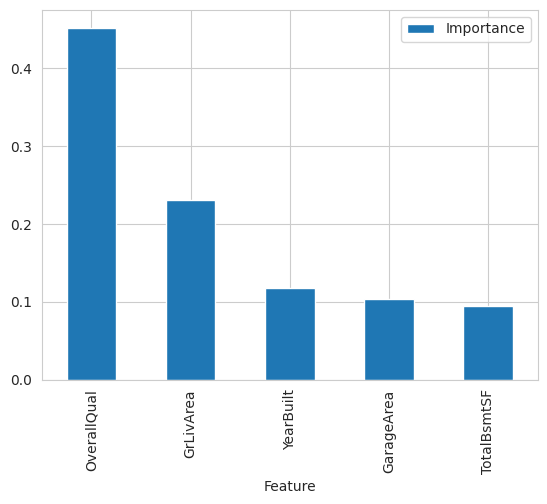

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

# after data cleaning and feature engineering, the features may have changes
# how many data cleaning and feature engineering steps does your pipeline have?
data_cleaning_feat_eng_steps = 9 
columns_after_data_cleaning_feat_eng = (Pipeline(best_regressor_pipeline.steps[:data_cleaning_feat_eng_steps])
                                        .transform(X_train)
                                        .columns)

best_features = columns_after_data_cleaning_feat_eng[best_regressor_pipeline['feat_selection'].get_support(
)].to_list()

# create DataFrame to display feature importance
df_feature_importance = (pd.DataFrame(data={
    'Feature': columns_after_data_cleaning_feat_eng[best_regressor_pipeline['feat_selection'].get_support()],
    'Importance': best_regressor_pipeline['model'].feature_importances_})
    .sort_values(by='Importance', ascending=False)
)

# Most important features statement and plot
print(f"* These are the {len(best_features)} most important features in descending order. "
      f"The model was trained on them: \n{df_feature_importance['Feature'].to_list()}")

df_feature_importance.plot(kind='bar', x='Feature', y='Importance')
plt.show()

### Evaluate on Train and Test Sets

In [18]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import numpy as np


def regression_performance(X_train, y_train, X_test, y_test, pipeline):
    print("Model Evaluation \n")
    print("* Train Set")
    regression_evaluation(X_train, y_train, pipeline)
    print("* Test Set")
    regression_evaluation(X_test, y_test, pipeline)


def regression_evaluation(X, y, pipeline):
    prediction = pipeline.predict(X)
    print('R2 Score:', r2_score(y, prediction).round(3))
    print('Mean Absolute Error:', mean_absolute_error(y, prediction).round(3))
    print('Mean Squared Error:', mean_squared_error(y, prediction).round(3))
    print('Root Mean Squared Error:', np.sqrt(
        mean_squared_error(y, prediction)).round(3))
    print("\n")


def regression_evaluation_plots(X_train, y_train, X_test, y_test, pipeline, alpha_scatter=0.5):
    pred_train = pipeline.predict(X_train)
    pred_test = pipeline.predict(X_test)

    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
    sns.scatterplot(x=y_train, y=pred_train, alpha=alpha_scatter, ax=axes[0])
    sns.lineplot(x=y_train, y=y_train, color='red', ax=axes[0])
    axes[0].set_xlabel("Actual")
    axes[0].set_ylabel("Predictions")
    axes[0].set_title("Train Set")

    sns.scatterplot(x=y_test, y=pred_test, alpha=alpha_scatter, ax=axes[1])
    sns.lineplot(x=y_test, y=y_test, color='red', ax=axes[1])
    axes[1].set_xlabel("Actual")
    axes[1].set_ylabel("Predictions")
    axes[1].set_title("Test Set")

    plt.show()

Evaluate Performance

Model Evaluation 

* Train Set
R2 Score: 0.934
Mean Absolute Error: 13959.92
Mean Squared Error: 405314289.747
Root Mean Squared Error: 20132.419


* Test Set
R2 Score: 0.844
Mean Absolute Error: 19827.147
Mean Squared Error: 1077513884.635
Root Mean Squared Error: 32825.507




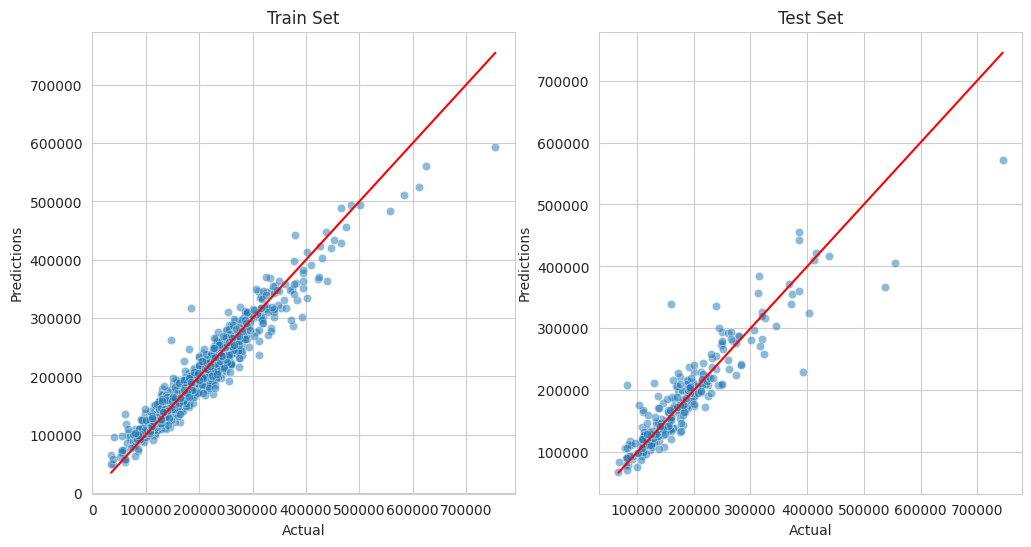

In [19]:
# Evaluate the performance of the best regression model on the training and testing datasets
# The "regression_performance" function takes the training and testing feature sets (X_train, X_test)
# and their corresponding target values (y_train, y_test), along with the optimized regressor pipeline
regression_performance(X_train, y_train, X_test, y_test, best_regressor_pipeline)

# Generate and display regression evaluation plots for the best regressor pipeline
regression_evaluation_plots(X_train, y_train, X_test, y_test, best_regressor_pipeline)

---

## Create ML Pipeline: Regressor with PCA


Let's explore potential values for PCA n_components.

In [20]:
# Initialize a classification pipeline using the LinearRegression model
pipeline = PipelineClf(model=LinearRegression())

# Create a truncated version of the pipeline that includes only the preprocessing steps up to the eighth step
pipeline_pca = Pipeline(pipeline.steps[:8])

# Apply the preprocessing pipeline on the features data (excluding 'SalePrice' which is the target variable)
df_pca = pipeline_pca.fit_transform(df.drop(['SalePrice'],axis=1))

# Print the shape of the transformed data
print(df_pca.shape,'\n', type(df_pca))

(1460, 20) 
 <class 'pandas.core.frame.DataFrame'>


Apply PCA separately to the scaled data

* The 17 components explain 100.0% of the data 



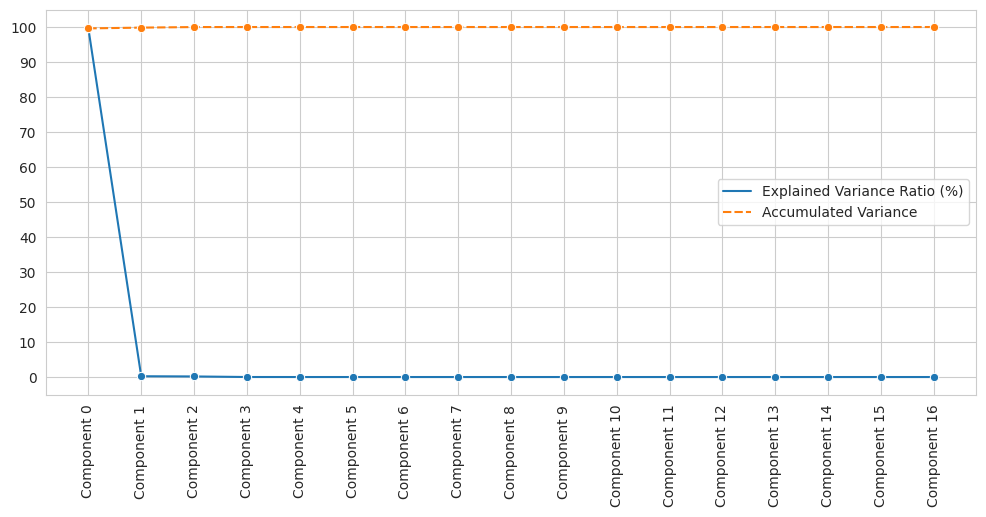

In [21]:
import numpy as np
from sklearn.decomposition import PCA

# Set the number of principal components to extract from the data.
n_components = 17


def pca_components_analysis(df_pca, n_components):
    # Initialize the PCA model with the specified number of components and fit it to the provided data.
    pca = PCA(n_components=n_components).fit(df_pca)
    x_PCA = pca.transform(df_pca)  # array with transformed PCA

    # Create a list of component names
    ComponentsList = ["Component " + str(number)
                      for number in range(n_components)]

    # Create a DataFrame to show the percentage of variance explained by each component
    dfExplVarRatio = pd.DataFrame(
        data=np.round(100 * pca.explained_variance_ratio_, 3),
        index=ComponentsList,
        columns=['Explained Variance Ratio (%)'])

    # Calculate the cumulative variance explained by the components
    dfExplVarRatio['Accumulated Variance'] = dfExplVarRatio['Explained Variance Ratio (%)'].cumsum(
    )

    # Calculate the total percentage of the variance explained by the selected components
    PercentageOfDataExplained = dfExplVarRatio['Explained Variance Ratio (%)'].sum(
    )

    print(
        f"* The {n_components} components explain {round(PercentageOfDataExplained,2)}% of the data \n")
    
    # Visualize the explained variance and accumulated variance in a line plot
    plt.figure(figsize=(12, 5))
    sns.lineplot(data=dfExplVarRatio,  marker="o")
    plt.xticks(rotation=90)
    plt.yticks(np.arange(0, 110, 10))
    plt.show()

# Call the function to perform PCA analysis on the preprocessed data with the specified number of components
pca_components_analysis(df_pca=df_pca, n_components=n_components)

The first principal component (Component 0) accounts for the vast majority of the variance in the dataset (99.61%), with the explained variance ratio steeply dropping off after it.
This implies that additional componenst contribute very little to explaining the variability in the dataset.

Since the first 4 components explain all the variance, this dataset could potentially be reduced to 4. 

Using fewer dimensions can lead to simpler models.

* The 1 components explain 99.61% of the data 



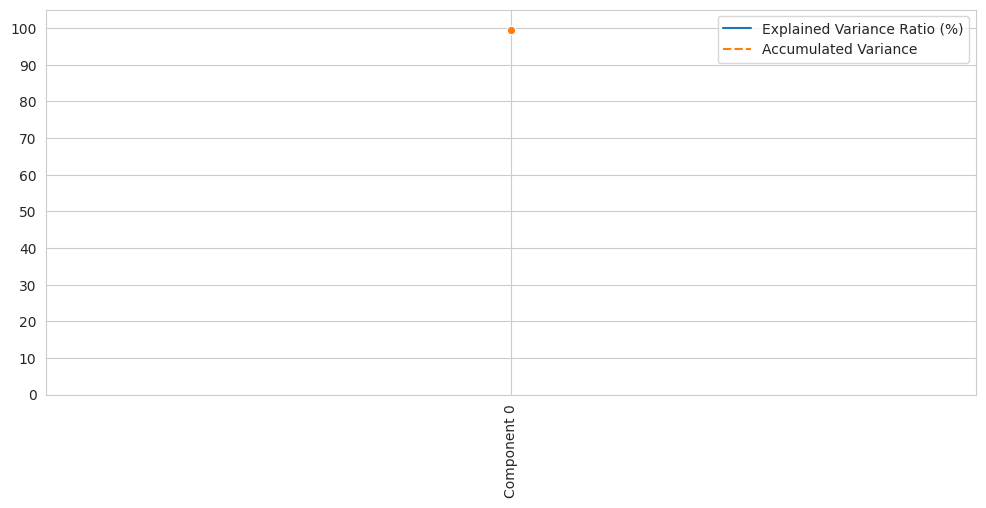

In [22]:
# Set the number of principal components to extract from the data to 1
n_components = 1

# Call the pca_components_analysis function to perform PCA with the specified number of components
pca_components_analysis(df_pca=df_pca,n_components=n_components)

* The 2 components explain 99.83% of the data 



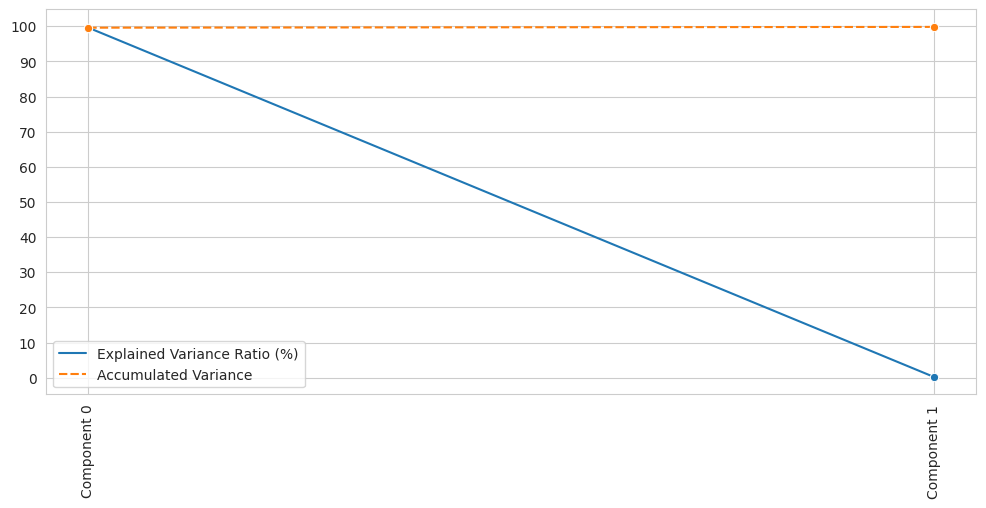

In [23]:
# Set the number of principal components to extract from the data to 2
n_components = 2

# Call the pca_components_analysis function to perform PCA with the specified number of components
pca_components_analysis(df_pca=df_pca,n_components=n_components)

* The 3 components explain 99.99% of the data 



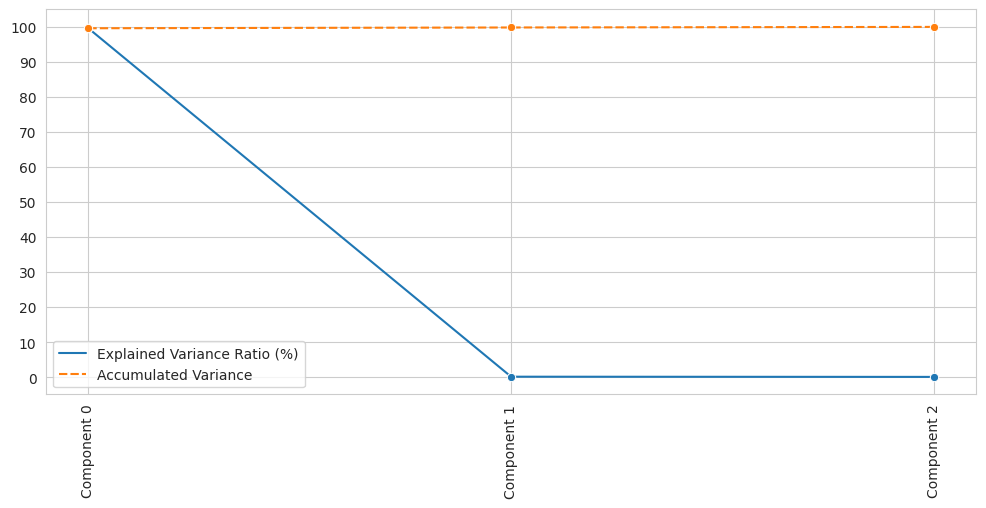

In [24]:
# Set the number of principal components to extract from the data to 3
n_components = 3

# Call the pca_components_analysis function to perform PCA with the specified number of components
pca_components_analysis(df_pca=df_pca,n_components=n_components)

* The 4 components explain 100.0% of the data 



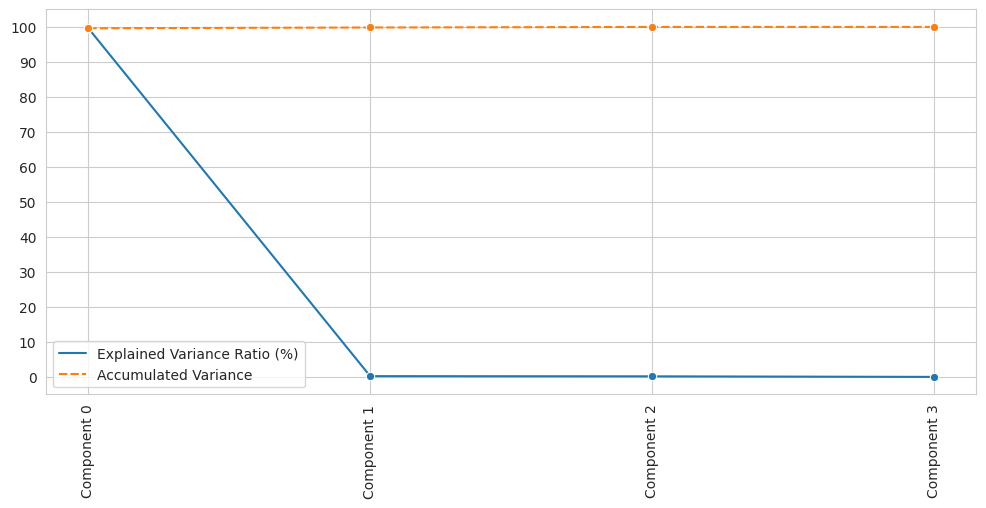

In [25]:
# Set the number of principal components to extract from the data to 4
n_components = 4

# Call the pca_components_analysis function to perform PCA with the specified number of components
pca_components_analysis(df_pca=df_pca,n_components=n_components)

### Rewrite ML Pipeline for Modelling

In [26]:
### PCA
from sklearn.decomposition import PCA

def PipelineClf(model):
  pipeline_base = Pipeline([
    # Data Cleaning
    ("DropFeatures", DropFeatures(features_to_drop=['EnclosedPorch', 'WoodDeckSF', 'GarageYrBlt'])),

    ("CustomCategoricalImputer", CustomCategoricalImputer()),
    
    ("ArbitraryNumberImputer",ArbitraryNumberImputer(arbitrary_number=0, 
                                                variables=['2ndFlrSF'])),
    
    ("MedianImputation", MeanMedianImputer(imputation_method='median', 
                                               variables=['LotFrontage', 'BedroomAbvGr', 'MasVnrArea'])), 
    # Feature Engineer
    ("OrdinalCategoricalEncoder",OrdinalEncoder(encoding_method='arbitrary', 
                                                variables = ['BsmtExposure', 'BsmtFinType1', 'GarageFinish', 'KitchenQual'])),

    ("LogTransformer",vt.LogTransformer(variables = ['GrLivArea', '1stFlrSF'])),

    ("PowerTransformer", PowerTransformer(variables=['BsmtUnfSF', 'BsmtFinType1', 'MasVnrArea', 'OpenPorchSF', 'TotalBsmtSF'])),

    ("YeoJohnsonTransformer", YeoJohnsonTransformer(variables=['GarageArea'])),                                                   

    ("SmartCorrelatedSelection",SmartCorrelatedSelection(variables=None, method="spearman", 
                                                        threshold=0.8, selection_method="variance")),
  
    ("feat_scaling",StandardScaler() ),

    ("PCA", PCA(n_components=4, random_state=0) ), 

    ("model",model ),  
  ])

  return pipeline_base

### Grid Search CV – Sklearn

In [27]:
print("* Train set:", X_train.shape, y_train.shape, "\n* Test set:",  X_test.shape, y_test.shape)

* Train set: (1168, 23) (1168,) 
* Test set: (292, 23) (292,)


Use standard hyperparameters to find the most suitable model.


In [28]:
models_quick_search = {
    'LinearRegression': LinearRegression(),
    "DecisionTreeRegressor": DecisionTreeRegressor(random_state=0),
    "RandomForestRegressor": RandomForestRegressor(random_state=0),
    "ExtraTreesRegressor": ExtraTreesRegressor(random_state=0),
    "AdaBoostRegressor": AdaBoostRegressor(random_state=0),
    "GradientBoostingRegressor": GradientBoostingRegressor(random_state=0),
    "XGBRegressor": XGBRegressor(random_state=0),
}

params_quick_search = {
    'LinearRegression': {},
    "DecisionTreeRegressor": {},
    "RandomForestRegressor": {},
    "ExtraTreesRegressor": {},
    "AdaBoostRegressor": {},
    "GradientBoostingRegressor": {},
    "XGBRegressor": {},
}

Do a quick optimisation search

In [29]:
# Initialize the HyperparameterOptimizationSearch with predefined models and their corresponding parameters
quick_search = HyperparameterOptimizationSearch(models=models_quick_search, params=params_quick_search)

# Fit the hyperparameter search object on the training data
quick_search.fit(X_train, y_train, scoring='r2', n_jobs=-1, cv=5)


Running GridSearchCV for LinearRegression 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWa


Running GridSearchCV for DecisionTreeRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWa


Running GridSearchCV for RandomForestRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWa


Running GridSearchCV for ExtraTreesRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWa


Running GridSearchCV for AdaBoostRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWa


Running GridSearchCV for GradientBoostingRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWa


Running GridSearchCV for XGBRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/workspace/.pip-modules/lib/python3.8/site-packages/xgboost/compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/workspace/.pip-modules/lib/python3.8/site-packages/xgboost/compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/workspace/.pip-modules/lib/python3.8/site-packages/xgboost/compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/workspace/.pip-modules/lib/python3.8/site-packages/xgboost/compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.In

Check the results.

In [30]:
# Retrieve a summary of the grid search results and the trained pipelines
grid_search_summary, grid_search_pipelines = quick_search.score_summary(sort_by='mean_score')
grid_search_summary

,estimator,min_score,mean_score,max_score,std_score
5,GradientBoostingRegressor,0.652659,0.804738,0.867665,0.077283
2,RandomForestRegressor,0.699632,0.800495,0.854916,0.053223
6,XGBRegressor,0.658771,0.794274,0.857414,0.070162
3,ExtraTreesRegressor,0.614072,0.78399,0.854727,0.08762
4,AdaBoostRegressor,0.6192,0.756833,0.800023,0.069145
0,LinearRegression,0.695485,0.75441,0.784203,0.03672
1,DecisionTreeRegressor,0.471431,0.6648,0.780608,0.107332


In [31]:
# Selects the top-performing model from the hyperparameter optimization search
best_pca_model = grid_search_summary.iloc[0,0]
best_pca_model

'GradientBoostingRegressor'

Parameters for best model

In [32]:
# Extract the best parameters for the highest performing model from the grid search
best_pca_parameters = grid_search_pipelines[best_pca_model].best_params_
best_pca_parameters

{}

Define the best regressor

In [33]:
# Obtain the best model instance configured with the optimal parameters that achieved the highest performance during the grid search
best_pca_regressor_pipeline = grid_search_pipelines[best_pca_model].best_estimator_
best_pca_regressor_pipeline

Pipeline(steps=[('DropFeatures',
                 DropFeatures(features_to_drop=['EnclosedPorch', 'WoodDeckSF',
                                                'GarageYrBlt'])),
                ('CustomCategoricalImputer', CustomCategoricalImputer()),
                ('ArbitraryNumberImputer',
                 ArbitraryNumberImputer(arbitrary_number=0,
                                        variables=['2ndFlrSF'])),
                ('MedianImputation',
                 MeanMedianImputer(variables=['LotFrontage', 'BedroomAbvGr',
                                              'MasVnrArea'])...
                                                     'BsmtExposure',
                                                     'BsmtFinSF1',
                                                     'BsmtFinType1',
                                                     'BsmtUnfSF', 'GarageArea',
                                                     'GarageFinish',
                                               

### Evaluate Regressor on Train and Tests Sets

Model Evaluation 

* Train Set
R2 Score: 0.919
Mean Absolute Error: 16041.546
Mean Squared Error: 499337611.212
Root Mean Squared Error: 22345.863


* Test Set
R2 Score: 0.836
Mean Absolute Error: 21491.445
Mean Squared Error: 1135810835.174
Root Mean Squared Error: 33701.793




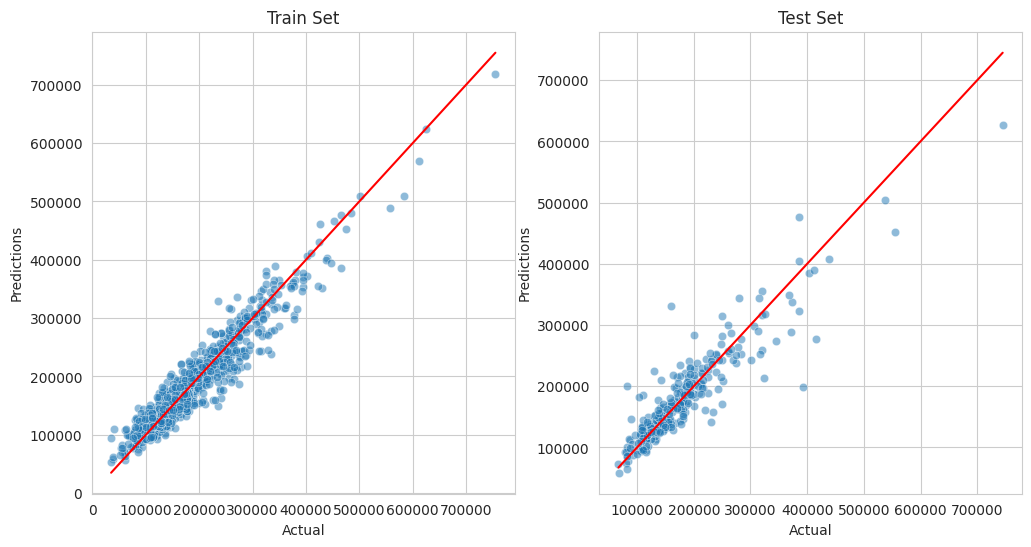

In [34]:
# Evaluate the performance of the best regression PCA model on the training and testing datasets
regression_performance(X_train, y_train, X_test, y_test,best_pca_regressor_pipeline)

# Generate and display regression evaluation plots for the best regressor PCA pipeline
regression_evaluation_plots(X_train, y_train, X_test, y_test,
                            best_pca_regressor_pipeline)

## Summary

### Model Performance Metrics

We executed two different pipelines, one using standard regression and another incorporating PCA (Principal Component Analysis). Let's review their outcomes:

1. **Standard Regression Model**:
    -  Train Set:
        -  R2 Score: 0.934
        - Mean Absolute Error (MAE): 13959.92
        - Mean Squared Error (MSE): 405314289.747
        - Root Mean Squared Error (RMSE): 20132.419
    - Test Set:
        - R2 Score: 0.844
        - Mean Absolute Error (MAE): 19827.147
        - Mean Squared Error (MSE): 1077513884.635
        - Root Mean Squared Error (RMSE): 32825.507

2. **Regression Model with PCA**:
    - Train Set:
        - R2 Score: 0.919
        - Mean Absolute Error (MAE): 16041.546
        - Mean Squared Error (MSE): 499337611.212
        - Root Mean Squared Error (RMSE): 22345.863
    
    - Test Set:
        - R2 Score: 0.836
        - Mean Absolute Error (MAE): 21491.445
        - Mean Squared Error (MSE): 1135810835.174
        - Root Mean Squared Error (RMSE): 33701.793

### Analysis of Performance Metrics

- **R2 Score**:
    - The standard regression model performs slightly better on the test set with an R2 score of 0.844 compared to 0.836 for the PCA-based model.

- **Error Metrics (MAE, MSE, RMSE)**:
    - Both models have higher errors on the test set compared to the training set, indicating some overfitting in both cases.
    - The PCA model has consistently higher errors across MAE, MSE, and RMSE on both training and testing sets compared to the standard model. <br> This might indicate that while PCA simplifies the model and reduces computation, it might also lose some critical information, impacting the model's overall predictive power.

The standard regression model seems to perform better overall, maintaining a higher R2 score and lower error metrics on both the training and test sets.

---

# Refit Pipeline with best features

We will now reconstruct the pipeline using the optimal configuration and focusing exclusively on the most effective features.

## Rewrite ML pipeline for Data Cleaning and Feature Engineering


Review the top-performing features:

In [35]:
best_features

['GarageArea', 'GrLivArea', 'OverallQual', 'TotalBsmtSF', 'YearBuilt']

Rewrite the pipeline to engineer only the most effective features.

In [36]:
def PipelineClf(model):
  pipeline_base = Pipeline([
    # Feature Engineer
    ("LogTransformer",vt.LogTransformer(variables = ['GrLivArea'])),

    ("PowerTransformer", PowerTransformer(variables=['TotalBsmtSF'])),

    ("YeoJohnsonTransformer", YeoJohnsonTransformer(variables=['GarageArea'])),                                                   
    
    # we don't need SmartCorrelatedSelection

    ("feat_scaling",StandardScaler() ),

    # no feature selection needed anymore

    ("model",model ),  
  ])

  return pipeline_base

## Split Train Test Set

In [37]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
                                    df.drop(['SalePrice'],axis=1),
                                    df['SalePrice'],
                                    test_size = 0.2,
                                    random_state = 0,
                                    )

# Print the shapes of the training and testing datasets to verify the sizes
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(1168, 23) (1168,) (292, 23) (292,)


### Subset best features

In this step, we refine our training and testing datasets to include only the most relevant features, identified as "best_features".

In [38]:
# Filter the training and testing datasets to include only the best-performing features identified earlier
X_train = X_train.filter(best_features)
X_test = X_test.filter(best_features)

# Print the dimensions of the filtered training and testing datasets
print("* Train set:", X_train.shape, y_train.shape, "\n* Test set:", X_test.shape, y_test.shape)

# Display the first few rows of the filtered training dataset
X_train.head()

* Train set: (1168, 5) (1168,) 
* Test set: (292, 5) (292,)


,GarageArea,GrLivArea,OverallQual,TotalBsmtSF,YearBuilt
618,774,1828,9,1822,2007
870,308,894,5,894,1962
92,432,964,5,876,1921
817,857,1689,8,1568,2002
302,843,1541,7,1541,2001


## Grid Search CV: Sklearn

In [39]:
models_search

{'ExtraTreesRegressor': ExtraTreesRegressor(random_state=0)}

Best parameters for the model

In [40]:
best_regressor_parameters

{'model__max_depth': 10,
 'model__min_samples_split': 8,
 'model__n_estimators': 100}

We add manually the best parameters:

In [41]:
params_search = {'ExtraTreesRegressor':  {
    'model__max_depth': [10], 
    'model__min_samples_split': [8],
    'model__n_estimators': [100],        
}
}
params_search

{'ExtraTreesRegressor': {'model__max_depth': [10],
  'model__min_samples_split': [8],
  'model__n_estimators': [100]}}

GridSearch CV

In [42]:
search = HyperparameterOptimizationSearch(models=models_search, params=params_search)
search.fit(X_train, y_train, scoring = 'r2', n_jobs=-1, cv=5)


Running GridSearchCV for ExtraTreesRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


Check Results

In [43]:
grid_search_summary, grid_search_pipelines = search.score_summary(sort_by='mean_score')
grid_search_summary

,estimator,min_score,mean_score,max_score,std_score,model__max_depth,model__min_samples_split,model__n_estimators
0,ExtraTreesRegressor,0.725415,0.826617,0.879445,0.054352,10,8,100


In [44]:
best_model = grid_search_summary.iloc[0,0]
best_model

'ExtraTreesRegressor'

In [45]:
best_regressor_pipeline = grid_search_pipelines[best_model].best_estimator_
best_regressor_pipeline

Pipeline(steps=[('LogTransformer', LogTransformer(variables=['GrLivArea'])),
                ('PowerTransformer',
                 PowerTransformer(variables=['TotalBsmtSF'])),
                ('YeoJohnsonTransformer',
                 YeoJohnsonTransformer(variables=['GarageArea'])),
                ('feat_scaling', StandardScaler()),
                ('model',
                 ExtraTreesRegressor(max_depth=10, min_samples_split=8,
                                     random_state=0))])

* These are the 5 most important features in descending order. The model was trained on them: 
['OverallQual', 'GrLivArea', 'YearBuilt', 'GarageArea', 'TotalBsmtSF']


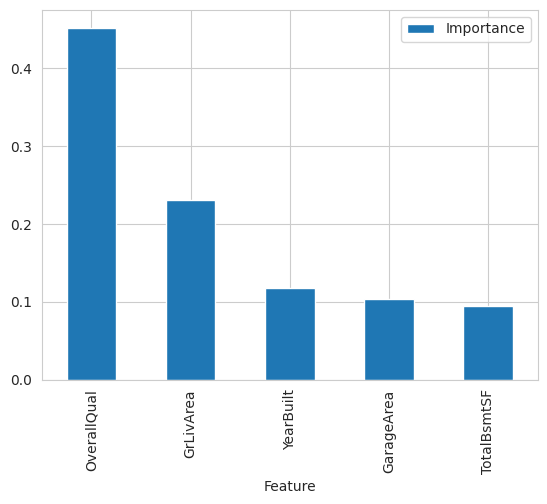

In [46]:
# how many data cleaning and feature engineering steps does your pipeline have?
data_cleaning_feat_eng_steps = 3 
columns_after_data_cleaning_feat_eng = (Pipeline(best_regressor_pipeline.steps[:data_cleaning_feat_eng_steps])
                                        .transform(X_train)
                                        .columns)

best_features = columns_after_data_cleaning_feat_eng

# create DataFrame to display feature importance
df_feature_importance = (pd.DataFrame(data={
    'Feature': columns_after_data_cleaning_feat_eng,
    'Importance': best_regressor_pipeline['model'].feature_importances_})
    .sort_values(by='Importance', ascending=False)
)

# Most important features statement and plot
print(f"* These are the {len(best_features)} most important features in descending order. "
      f"The model was trained on them: \n{df_feature_importance['Feature'].to_list()}")

df_feature_importance.plot(kind='bar', x='Feature', y='Importance')
plt.show()

Model Evaluation 

* Train Set
R2 Score: 0.934
Mean Absolute Error: 13959.92
Mean Squared Error: 405314289.747
Root Mean Squared Error: 20132.419


* Test Set
R2 Score: 0.844
Mean Absolute Error: 19827.147
Mean Squared Error: 1077513884.635
Root Mean Squared Error: 32825.507




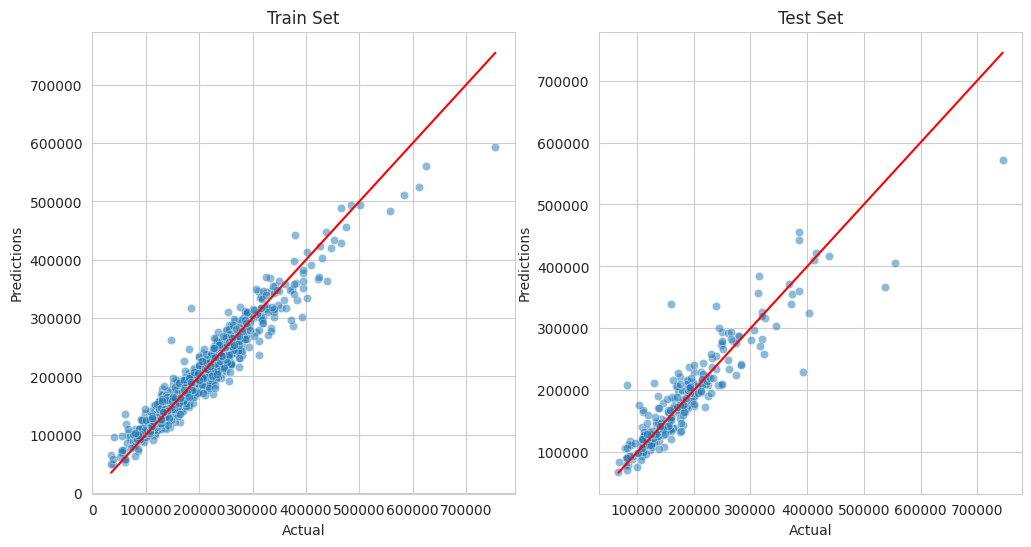

In [47]:
regression_performance(X_train, y_train, X_test, y_test, best_regressor_pipeline)
regression_evaluation_plots(X_train, y_train, X_test, y_test, best_regressor_pipeline)

# Push files to Repo

We will generate the following files

- Train set
- Test set
- Data cleaning and Feature Engineering pipeline
- Modeling pipeline
- Features importance plot

In [48]:
import joblib
import os

version = 'v1'
file_path = f'outputs/ml_pipeline/predict_sale_price/{version}'

try:
  os.makedirs(name=file_path)
except Exception as e:
  print(e)

[Errno 17] File exists: 'outputs/ml_pipeline/predict_sale_price/v1'


## Train Set: Features and Target

In [49]:
# Print the shape of the training dataset
print(X_train.shape)

# Display the first few rows of the training dataset
X_train.head()

(1168, 5)


,GarageArea,GrLivArea,OverallQual,TotalBsmtSF,YearBuilt
618,774,1828,9,1822,2007
870,308,894,5,894,1962
92,432,964,5,876,1921
817,857,1689,8,1568,2002
302,843,1541,7,1541,2001


In [50]:
# Save the training dataset, X_train, to a CSV file without including the row indices
X_train.to_csv(f"{file_path}/X_train.csv", index=False)

In [51]:
# Print the shape of the target variable dataset
print(y_train.shape)

# Display the first few entries of the target dataset
y_train.head()

(1168,)


618    314813
870    109500
92     163500
817    271000
302    205000
Name: SalePrice, dtype: int64

In [52]:
# Save the training dataset, y_train, to a CSV file without including the row indices
y_train.to_csv(f"{file_path}/y_train.csv", index=False)

## Test Set: Features and Target

In [53]:
# Print the shape of the test dataset
print(X_test.shape)

# Display the first few rows of the test dataset
X_test.head()

(292, 5)


,GarageArea,GrLivArea,OverallQual,TotalBsmtSF,YearBuilt
529,484,2515,6,2035,1957
491,240,1578,6,806,1941
459,352,1203,5,709,1950
279,505,2022,7,1160,1977
655,264,1092,6,525,1971


In [54]:
# Save the test dataset, X_test, to a CSV file without including the row indices
X_test.to_csv(f"{file_path}/X_test.csv", index=False)

In [55]:
# Print the shape of the target variable dataset
print(y_test.shape)

# Display the first few entries of the target dataset
y_test.head()

(292,)


529    200624
491    133000
459    110000
279    192000
655     88000
Name: SalePrice, dtype: int64

In [56]:
# Save the test dataset, y_test, to a CSV file without including the row indices
y_test.to_csv(f"{file_path}/y_test.csv", index=False)

## Modelling pipeline

In [57]:
# Display the best regressor pipeline object
# This pipeline includes all preprocessing steps and the regression model that was optimized and identified as best performing through hyperparameter tuning
best_regressor_pipeline

Pipeline(steps=[('LogTransformer', LogTransformer(variables=['GrLivArea'])),
                ('PowerTransformer',
                 PowerTransformer(variables=['TotalBsmtSF'])),
                ('YeoJohnsonTransformer',
                 YeoJohnsonTransformer(variables=['GarageArea'])),
                ('feat_scaling', StandardScaler()),
                ('model',
                 ExtraTreesRegressor(max_depth=10, min_samples_split=8,
                                     random_state=0))])

In [58]:
# Save the optimized regression pipeline "best_regressor_pipeline" to a file using joblib
joblib.dump(value=best_regressor_pipeline, filename=f"{file_path}/best_regressor_pipeline.pkl")

['outputs/ml_pipeline/predict_sale_price/v1/best_regressor_pipeline.pkl']

## Feature importance plot

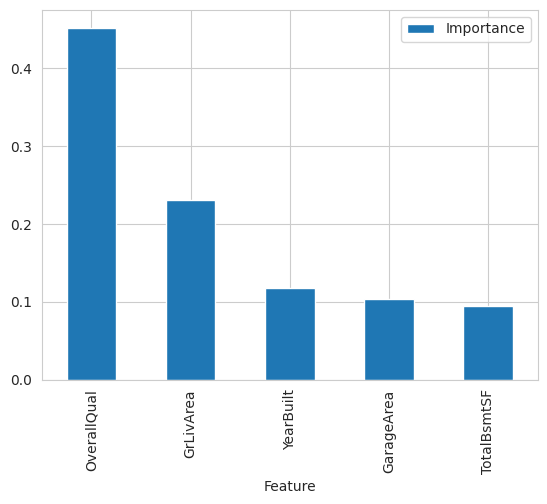

In [59]:
# Generate a bar plot to visualize the importance of each feature used in the model
df_feature_importance.plot(kind='bar', x='Feature', y='Importance')

# Display the plot
plt.show()

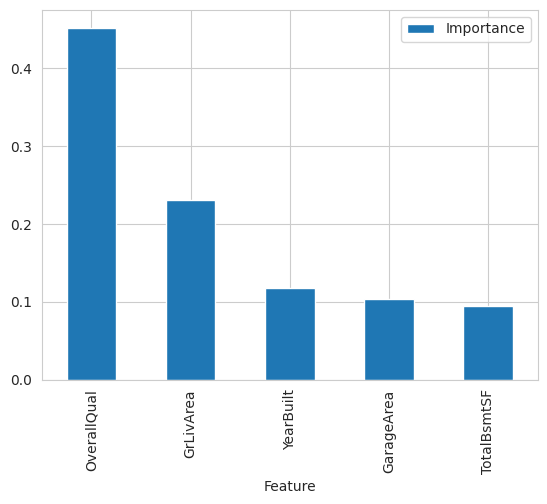

In [60]:
# Generate a bar plot to visualize the importance of each feature used in the model
df_feature_importance.plot(kind='bar',x='Feature',y='Importance')

# Save the generated plot to a PNG file at the specified location12
plt.savefig(f'{file_path}/features_importance.png', bbox_inches='tight')

# Conclusion

The standard regression model with best features has been chosen to predic the sale price.

- **Strong training performance**: 
    - The model achieves a high R2 score of 0.934 on the training set, indicating excellent predictive accuracy within the known data.

- **Test Data**: 
    - The drop in R2 score to 0.844 on the test set suggests that while the model is robust, it experiences a typical decline when predicting new data.
    - This is a common trait in predictive modeling, where performance on unseen data slightly drops.

- **Error Metrics (MAE, MSE, RMSE)**:
    - The disparity between training and testing performance, particularly the increase in error metrics, points towards overfitting.
    - The model learns the training data too well, including its noise and exceptions, which does not generalize well on the test data.
    - Despite the overfitting indications, the model retains a relatively strong generalization capability on the test set with an R2 score of 0.844.



In summary, the current standard regression model shows strong predictive power with the best-selected features but would benefit from strategies aimed at reducing overfitting to enhance its predictive accuracy on unseen data.

The performance target of achieving an R2 score of at least 0.75 in both the training and testing datasets has been successfully achieved.